In [6]:
import numpy as np
import pandas as pd
import statsrat as sr
from statsrat import latent_cause as lc
from statsrat.expr.predef.pvl_no_iti import aab_renewal as task

In [7]:
model = lc.model(name = 'constant', kernel = lc.kernel.constant)
#model = lc.model(name = 'power', kernel = lc.kernel.power)
#model = lc.model(name = 'exponential', kernel = lc.kernel.exponential)
print(model.pars)

method = 'particle'
#method = 'local_vb'
perform_oat = True

prior_tau2_x = 0.5
prior_tau2_y = 0.2
prior_n = 2.0
alpha = 2.0
stick = 0.0
power = 5.0
gamma = 2.0

pm_prec_x = (prior_n*(prior_n + 3))/(prior_n*prior_tau2_x - 0**2)
pm_prec_y = (prior_n*(prior_n + 3))/(prior_n*prior_tau2_y - 0**2)
print('\nprior mean precision for x = ' + str(np.round(pm_prec_x, 2)))
print('prior mean precision for y = ' + str(np.round(pm_prec_y, 2)))

par_vals = {'constant': [prior_tau2_x, prior_n, prior_tau2_y, prior_n, stick, alpha, 5.0],
            'power': [power, prior_tau2_x, prior_n, prior_tau2_y, prior_n, stick, alpha, 5.0],
            'exponential': [gamma, prior_tau2_x, prior_n, prior_tau2_y, prior_n, stick, alpha, 5.0]}

               min   max  default  \
prior_tau2_x  0.01  10.0      1.0   
prior_nu_x    1.00  10.0      5.0   
prior_tau2_y  0.01  10.0      1.0   
prior_nu_y    1.00  10.0      5.0   
stick         0.00   5.0      1.0   
alpha         0.00  15.0      1.0   
resp_scale    0.00  10.0      1.0   

                                                    description  
prior_tau2_x                 prior hyperparameter for eta for x  
prior_nu_x                   prior hyperparameter for eta for x  
prior_tau2_y                 prior hyperparameter for eta for y  
prior_nu_y                   prior hyperparameter for eta for y  
stick                                  stickiness for CRP prior  
alpha         concentration parameter; higher -> tend to inf...  
resp_scale           scales softmax/logistic response functions  

prior mean precision for x = 10.0
prior mean precision for y = 25.0


AAB renewal 

-0.0008727311518784697
       schedule     trial_name u_name  mean_resp
0  experimental  cs -> nothing     us   0.509146
0       control  cs -> nothing     us   0.510018


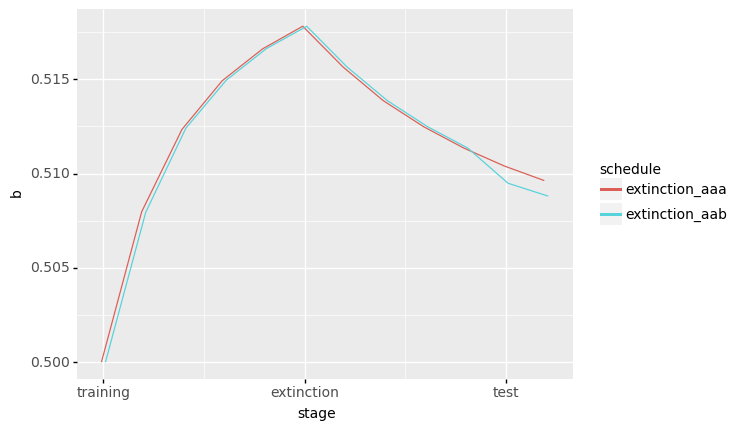

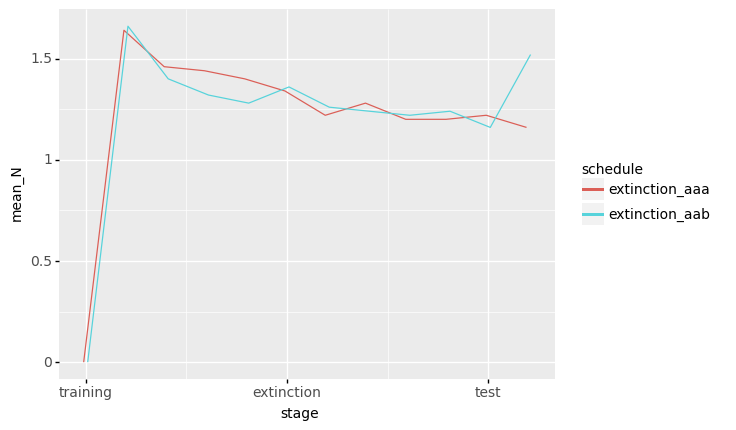

In [8]:
print('AAB renewal \n')

trials_exp = task.make_trials('experimental')
trials_ctl = task.make_trials('control')

if method == 'particle':
    ds_exp = model.particle_filter(trials_exp, par_vals[model.name], n_p = 50)
    ds_ctl = model.particle_filter(trials_ctl, par_vals[model.name], n_p = 50)
    sr.multi_plot([ds_exp, ds_ctl], var = 'b', dodge_width = 0.2).draw()
    sr.multi_plot([ds_exp, ds_ctl], var = 'mean_N', dodge_width = 0.2).draw()
else:
    ds_exp = model.simulate(trials_exp, par_vals[model.name])
    ds_ctl = model.simulate(trials_ctl, par_vals[model.name])

oat_name = list(task.oats.keys())[0]
print(task.oats[oat_name].compute_total({'experimental': ds_exp, 'control': ds_ctl}))
print(task.oats[oat_name].mean_resp({'experimental': ds_exp, 'control': ds_ctl}))

In [9]:
if method == 'local':
    print('experimental condition \n')

    df_exp = ds_exp['z'].to_dataframe()
    table_exp = pd.crosstab(df_exp['z'], df_exp['ex'])
    print(ds_exp['z'].values)
    print(table_exp)
    
    print('control condition \n')

    df_ctl = ds_ctl['z'].to_dataframe()
    table_ctl = pd.crosstab(df_ctl['z'], df_ctl['ex'])
    print(ds_ctl['z'].values)
    print(table_ctl)
    
    sel = {'z_name': ['0', '1', '2', '3']}
    sr.learn_plot(ds_exp, var = 'phi_x', sel = sel, only_main = True).draw()
    sr.learn_plot(ds_exp, var = 'est_mu_y', sel = sel).draw()
    sr.learn_plot(ds_exp, var = 'est_mu_x', sel = sel).draw()
    sr.learn_plot(ds_exp, var = 'est_precision_x', sel = sel).draw()

In [10]:
if perform_oat:
    n_dict = {'local_vb': 1, 'particle': 10}
    oat_result = sr.perform_oat(model = model,
                                experiment = task,
                                n = n_dict[method],
                                minimize = False,
                                sim_type = method)
    print(np.round(oat_result[0], 4))
    print(np.round(oat_result[1], 4))

Maximizing OAT score.
     prior_tau2_x  prior_nu_x  prior_tau2_y  prior_nu_y  stick   alpha  \
max         2.508      7.7495         5.005         5.5    2.5  2.5007   

       mean   lower   upper  
max -0.0003 -0.0005 -0.0002  
       schedule     trial_name u_name  mean_resp
0  experimental  cs -> nothing     us     0.5073
0       control  cs -> nothing     us     0.5076
